In [2]:
audio_train_files = os.listdir('/Users/Aiswaryaa/all/audio_musical_train')


train = pd.read_csv('/Users/Aiswaryaa/all/train_music.csv')


In [3]:
SAMPLE_RATE = 44100

def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

# Generate mfcc features with mean and standard deviation
def get_mfcc(name, path):
    data, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        ft1 = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=30)
        ft2 = librosa.feature.zero_crossing_rate(data)[0]
        ft3 = librosa.feature.spectral_rolloff(data)[0]
        ft4 = librosa.feature.spectral_centroid(data)[0]
        ft5 = librosa.feature.spectral_contrast(data)[0]
        ft6 = librosa.feature.spectral_bandwidth(data)[0]
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
        return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    except:
        print('bad file')
        return pd.Series([0]*210)

In [1]:
import numpy as np
import pandas as pd

import os
import librosa

import scipy
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas

tqdm.pandas()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC

In [5]:
train_data = pd.DataFrame()
train_data['fname'] = train['fname']
#test_data = pd.DataFrame()
#test_data['fname'] = audio_test_files

train_data = train_data['fname'].progress_apply(get_mfcc, path='/Users/Aiswaryaa/all/audio_musical_train/')
print('done loading train mfcc')
#test_data = test_data['fname'].progress_apply(get_mfcc, path='../input/audio_test/')
#print('done loading test mfcc')

train_data['fname'] = train['fname']
#test_data['fname'] = audio_test_files

train_data['label'] = train['label']
#test_data['label'] = np.zeros((len(audio_test_files)))

100%|██████████| 4336/4336 [15:46<00:00,  2.94it/s]

done loading train mfcc


In [6]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,fname,label
0,-375.754678,151.572502,-41.933635,-0.165071,5.955898,-12.535086,-13.192531,-13.657687,-9.174413,-19.668802,...,34.161463,6.676251,906.662232,506.447373,3.305549,3388.692162,733.209469,3388.692162,001ca53d.wav,Saxophone
1,-658.236035,102.368917,20.626247,9.108918,-4.891736,7.259463,-1.862530,1.661778,5.499974,5.338336,...,18.050029,8.280023,2840.134501,611.530727,-0.202585,3631.676275,2698.475507,3631.676275,002d256b.wav,Trumpet
2,-770.905450,16.077204,-3.556132,-10.957762,-19.071291,-9.632298,4.279781,14.633798,19.459229,12.089039,...,20.719852,13.943471,2758.526365,772.741940,-0.909257,3553.924270,3235.174665,3553.924270,0033e230.wav,Glockenspiel
3,-343.603965,137.873119,-28.701815,8.593180,2.751699,-0.301433,-9.502459,-3.774746,13.056789,7.197487,...,23.051968,8.232091,1639.312250,657.051222,1.086833,3113.026574,1267.272974,3113.026574,00353774.wav,Cello
4,-419.995811,220.987791,27.719369,21.398867,25.172284,19.790138,-5.250976,-1.614069,-3.515045,-3.540092,...,24.136753,12.163386,869.704859,171.794464,4.455394,2372.706817,836.479043,2372.706817,003b91e8.wav,Cello


In [7]:
X = train_data.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values])

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
pca = PCA(n_components=65).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.3, random_state = 42)


In [12]:
clf = SVC(kernel = 'rbf', probability=True)


In [13]:
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
print(accuracy_score(clf.predict(X_val), y_val))

0.7847809377401999


In [15]:
C_grid = [0.001, 0.01, 0.1, 1, 10]
gamma_grid = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': C_grid, 'gamma' : gamma_grid}

grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv = 3, scoring = "accuracy")
grid.fit(X_train, y_train)

# Find the best model
print(grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

0.7769357495881384
{'C': 10, 'gamma': 0.01}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [16]:
clf = SVC(kernel = 'rbf', C = 4, gamma = 0.01, probability=True)

clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.8270561106840891


In [17]:
print(confusion_matrix(clf.predict(X_val), y_val))

[[69  0  4  2  0  1  1  1  0  4  0  0  0  0  1  1  1]
 [ 0 81  0  0  0  0  1  1  0  0  0  0  1  5  0  1  0]
 [ 2  0 71  0  0  4  2  1  0  8  1  0  3  0  0  3  1]
 [ 0  0  0 25  0  0  0  1  2  0  1  0  0  1  1  0  0]
 [ 0  0  1  0 83  0  0  3  0  0  2  3  3  0  0  3  0]
 [ 0  2  1  0  0 86  1  0  0  3  0  0  0  0  0  0  0]
 [ 2  1  1  0  0  1 29  0  0  1  0  0  0  0  0  0  0]
 [ 6  3  3  3  4  0  1 64  0  6  4  0  5  1  1  4  2]
 [ 0  0  0  0  0  0  1  1 28  0  0  0  0  0  0  0  1]
 [ 2  1  1  0  0  2  1  1  0 55  0  0  1  2  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 34  0  1  1  0  1  2]
 [ 0  0  0  0  6  0  0  0  0  0  0 78  1  0  0  1  0]
 [ 0  0  3  0  3  2  1  4  0  1  2  1 87  0  0  6  3]
 [ 2  3  0  0  0  0  0  1  0  1  0  0  0 83  5  0  1]
 [ 0  0  0  1  0  0  0  0  0  1  0  0  0  0 55  0  0]
 [ 0  0  1  1  0  1  0  2  0  3  0  1  1  1  0 74  2]
 [ 3  0  3  0  0  0  0  5  0  1  0  0  1  1  0  2 74]]


In [18]:
cm=confusion_matrix(clf.predict(X_val), y_val)

In [19]:
p=list()
for i in range(len(cm)):
    d=0
    for j in range(len(cm[i])):
        d=d+ cm[j][i]
    p.append(cm[i][i]/d)

In [20]:
print(p)
print(len(p))

[0.8023255813953488, 0.8901098901098901, 0.797752808988764, 0.7575757575757576, 0.8645833333333334, 0.8865979381443299, 0.7631578947368421, 0.7529411764705882, 0.9333333333333333, 0.6547619047619048, 0.7727272727272727, 0.9397590361445783, 0.8365384615384616, 0.8736842105263158, 0.873015873015873, 0.7708333333333334, 0.8505747126436781]
17


In [21]:
r=list()
for i in range(len(cm)):
    d=0
    for j in range(len(cm[i])):
        d=d+ cm[i][j]
    r.append(cm[i][i]/d)

In [22]:
print(r)
print(len(r))
b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
print(len(b))

[0.8117647058823529, 0.9, 0.7395833333333334, 0.8064516129032258, 0.8469387755102041, 0.9247311827956989, 0.8285714285714286, 0.5981308411214953, 0.9032258064516129, 0.8333333333333334, 0.85, 0.9069767441860465, 0.7699115044247787, 0.8645833333333334, 0.9649122807017544, 0.8505747126436781, 0.8222222222222222]
17
17


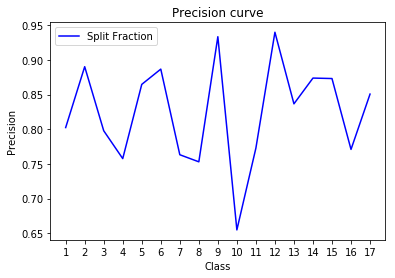

In [30]:
import matplotlib.pyplot as plt

b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.plot(b, p, 'b', label='Split Fraction')
plt.title('Precision curve')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.legend()

plt.show()

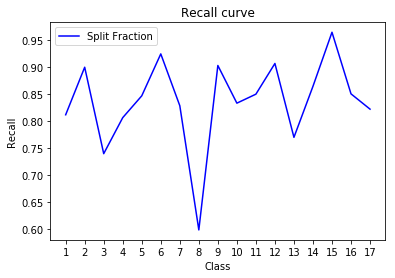

In [24]:
import matplotlib.pyplot as plt

b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.plot(b, r, 'b', label='Split Fraction')
plt.title('Recall curve')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [25]:
f=list()
for i in range(len(r)):
    f.append(2*p[i]*r[i]/(p[i]+r[i]))

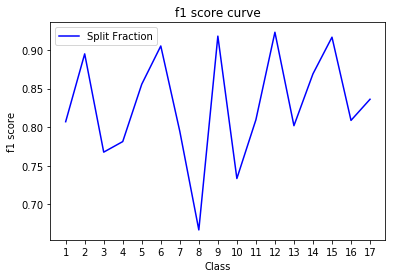

In [26]:
import matplotlib.pyplot as plt

b=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.plot(b, f, 'b', label='Split Fraction')
plt.title('f1 score curve')
plt.xlabel('Class')
plt.ylabel('f1 score')
plt.legend()

plt.show()

In [27]:
avgp=0
c=0
for i in range(len(p)):
    c=c+p[i]
avgp=(c/17)
print("avg precision",avgp)

avg precision 0.8247219128693885


In [28]:
avgr=0
c=0
for i in range(len(r)):
    c=c+r[i]
avgr=(c/17)
print("avg Recall",avgr)

avg Recall 0.8365830480832058


In [29]:
avgf=0
c=0
for i in range(len(f)):
    c=c+f[i]
avgf=(c/17)
print("avg F1 score",avgf)

avg F1 score 0.8287924328192713
